In [57]:
%matplotlib notebook

In [58]:
import os
# For windows
# os.environ['PROJ_LIB'] = 'C:\Anaconda\Library\share'

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import LinearNDInterpolator
from pyproj import transform, Proj

# Linux
# plt.rcParams['animation.ffmpeg_path'] = '~/miniconda2/envs/particles/bin/ffmpeg'

# Windows
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\Anaconda\\envs\\py37\\'

# plt.rcParams['animation.bitrate'] = 2000

In [59]:
# зададим константы
NUM_PARTICLES = 100
NUM_ITER = 24*7
STEP = 3600  # sec
SEED = 42

Uw, Vw = 100, 100 # см/с
W = np.array([Uw, Vw])

In [60]:
# системы координат
wgs84 = Proj(init="EPSG:4326")
local_crs = Proj(init="EPSG:2463")

In [65]:
lonlat

array([[19.19, 54.35],
       [19.19, 54.36],
       [19.19, 54.37],
       ...,
       [21.06, 55.44],
       [21.06, 55.45],
       [21.06, 55.46]])

In [62]:
# получаем данные из файла
data = np.genfromtxt('6.csv', delimiter=';', skip_header=True)
data[data==-999] = np.nan
lonlat, current_velocity = data[:, 1::-1], data[:, 2:]

x, y = transform(wgs84, local_crs, lonlat[:, 0], lonlat[:, 1])
xy = np.vstack([x, y]).T

<IPython.core.display.Javascript object>


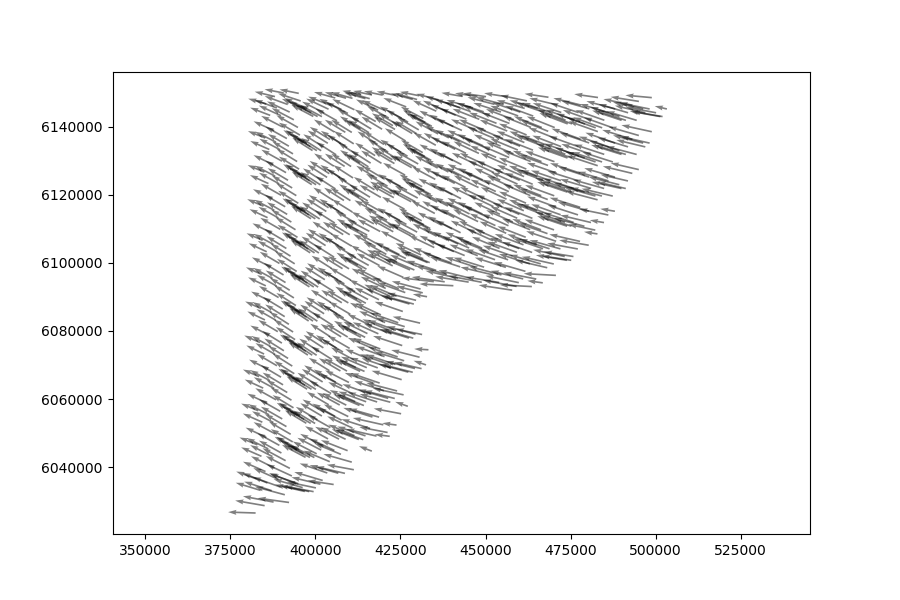

In [63]:
# посмотрим на данные
fig, ax = plt.subplots(figsize=(9,6))
ax.quiver(xy[::10, 0], xy[::10, 1], current_velocity[::10, 0], current_velocity[::10, 1], scale=200, scale_units='width', alpha=0.5)
ax.axis('equal')
pass

In [44]:
# создадим функцию интерполяции данных
get_current_velocity = LinearNDInterpolator(xy, current_velocity)

def get_velocity(xy, speed_param):
    C = get_current_velocity(xy)
    velocity = (C + speed_param * W) / (1 + speed_param)
    velocity *= 0.01  # переведем из см/с в м/с
    return velocity

In [45]:
# типы точек
point_types = pd.read_excel('Particles 1.xlsx')
point_types.columns = ['type', 'number', 'speed_param']
# присвоим каждому типу свой цвет
scalar_map = mpl.cm.ScalarMappable(
    cmap='jet',
    norm=mpl.colors.Normalize(
        vmin=point_types.type.min(),
        vmax=point_types.type.max()
    )
)

point_types['color'] = point_types.type.apply(lambda type_: scalar_map.to_rgba(type_))
point_types.set_index('type', inplace=True)
point_types

,number,speed_param,color
type,,,
1,50,0.010356,"(0.0, 0.0, 0.5, 1.0)"
2,50,0.005979,"(0.0, 0.8333333333333334, 1.0, 1.0)"
3,50,0.116554,"(1.0, 0.9012345679012348, 0.0, 1.0)"
4,50,0.013370,"(0.5, 0.0, 0.0, 1.0)"


In [46]:
# получим гранницы данных
bounds = np.hstack([xy.min(axis=0), xy.max(axis=0)])
bounds_lonlat = np.hstack([lonlat.min(axis=0), lonlat.max(axis=0)])

In [47]:
# рассчитаем состояние системы на каждой итерации для каждой частицы
# state - 3-мерный массив [NUM_ITER х NUM_PARTICLES х 4]
# по последней оси размерностью 4 храним X, Y, Vx, Vy

def init_state(xy, speed_param):
    """Инициализация состояния системы"""
    velocity = get_velocity(xy, speed_param)
    return np.hstack([xy, velocity])

def get_state(state_prev, step, speed_param):
    """Получает текущее состояние по предыдущему"""
    xy_prev = state_prev[:, :2]
    velocity_prev = state_prev[:, 2:]
    xy_cur = xy_prev + step*velocity_prev
    velocity_cur = get_velocity(xy_cur, speed_param)
    states_cur = np.hstack([xy_cur, velocity_cur])
    return states_cur

# точки расположены в виде прямоугольника
x_min, y_min, x_max, y_max = bounds
rs = np.random.RandomState(SEED)
x_delta = x_max - x_min
xmin_, xmax_ = x_min + 0.2*x_delta, x_min + 0.4*x_delta
y_delta = y_max - y_min
ymin_, ymax_ = y_min + 0.4*y_delta, y_min + 0.6*y_delta
n = np.ceil(np.sqrt(point_types.number.sum())).astype(int)
xm, ym = np.meshgrid(np.linspace(xmin_, xmax_, n), np.linspace(ymin_, ymax_, n))
xy_init = np.vstack([xm.ravel(), ym.ravel()]).T
rs.shuffle(xy_init)  # перемешаем, чтобы точки чередовались по типу

# запустим расчет
p_type_states = {}
for i, (p_type, row) in enumerate(point_types.iterrows()):
    num_points = row.number
    speed_param = row.speed_param
    states = np.ones([NUM_ITER, num_points, 4], dtype=float) * np.nan
    states[0, :, :] = init_state(xy_init[i * num_points: (i + 1) * num_points], speed_param)
    for n in range(1, NUM_ITER):
        states[n, :, :] = get_state(states[n-1, :, :], STEP, speed_param)        
    p_type_states[p_type] = states

[[-0.08097903  0.02919988]
 [-0.06277547  0.03590298]
 [-0.0587519   0.03648358]
 [-0.07400203  0.03320756]
 [-0.08228819  0.02510609]
 [-0.06203275  0.03590831]
 [-0.06032347  0.03614806]
 [-0.08120954  0.02737302]
 [-0.07876072  0.03021548]
 [-0.07334121  0.03327524]
 [-0.07464918  0.03282541]
 [-0.05871151  0.037     ]
 [-0.0635338   0.03580191]
 [-0.08202572  0.02819977]
 [-0.05856845  0.03696452]
 [-0.05851491  0.0369    ]
 [-0.058495    0.03678091]
 [-0.07540101  0.03239756]
 [-0.08086653  0.02769559]
 [-0.0586177   0.03632913]
 [-0.06474633  0.03582362]
 [-0.0646485   0.03578784]
 [-0.06065333  0.03614252]
 [-0.0610411   0.03613699]
 [-0.06860386  0.03488763]
 [-0.07185251  0.03387127]
 [-0.07709751  0.03168769]
 [-0.06813058  0.0347649 ]
 [-0.06919025  0.03486992]
 [-0.07089905  0.01766729]
 [-0.08342849  0.02144558]
 [-0.05847496  0.0367    ]
 [-0.06026681  0.03687866]
 [-0.06111132  0.03608245]
 [-0.06482321  0.0357    ]
 [-0.08310642  0.02510434]
 [-0.05816398  0.0365    ]
 

[[-0.05605036  0.03130056]
 [        nan         nan]
 [        nan         nan]
 [-0.05803628  0.03543598]
 [-0.05752436  0.0356143 ]
 [        nan         nan]
 [        nan         nan]
 [-0.0571047   0.03466074]
 [-0.05766916  0.03575876]
 [-0.05798743  0.03361942]
 [-0.055307    0.0289623 ]
 [        nan         nan]
 [        nan         nan]
 [-0.05671984  0.03339839]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [-0.05806757  0.03476664]
 [-0.05733183  0.0346353 ]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [-0.04767833  0.02110349]
 [-0.05254294  0.02514554]
 [-0.05775823  0.03581265]
 [-0.05282822  0.02509688]
 [-0.05842053  0.03364278]
 [-0.05683554  0.03604451]
 [-0.05723031  0.0356276 ]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [-0.04781866  0.02064046]
 [-0.05742681  0.03522977]
 [        nan         nan]
 

[[-0.0569      0.03645072]
 [-0.05673877  0.03561987]
 [-0.04802123  0.02141872]
 [-0.05703965  0.03397208]
 [-0.05689079  0.03599068]
 [-0.05677005  0.03504643]
 [-0.0568      0.03534717]
 [-0.05642482  0.03658417]
 [-0.04713102  0.02063864]
 [-0.0569      0.0364503 ]
 [-0.05661179  0.03569424]
 [-0.05666373  0.0356088 ]
 [-0.05655133  0.03635531]
 [-0.05262141  0.02625661]
 [-0.04777745  0.02118546]
 [-0.05651906  0.03239034]
 [-0.05634105  0.03645895]
 [-0.05557227  0.03028761]
 [-0.05648572  0.03611428]
 [-0.05727418  0.03389672]
 [        nan         nan]
 [        nan         nan]
 [-0.05575038  0.03022061]
 [-0.05624175  0.02965897]
 [-0.05755555  0.03594445]
 [-0.05693556  0.0364    ]
 [        nan         nan]
 [-0.05643284  0.03617766]
 [-0.05559778  0.03033631]
 [-0.05657672  0.03621776]
 [-0.05664306  0.03611994]
 [-0.05623399  0.02973783]
 [-0.05716319  0.03508444]
 [-0.04725916  0.02089437]
 [-0.05644947  0.03238578]
 [        nan         nan]
 [        nan         nan]
 

[[-0.05670422  0.03365506]
 [-0.05707518  0.0365    ]
 [-0.05648968  0.03611032]
 [-0.05702674  0.0335113 ]
 [-0.05781528  0.03664314]
 [-0.05605639  0.03127357]
 [-0.05721906  0.0364    ]
 [-0.05667732  0.0366    ]
 [-0.05650795  0.03081291]
 [-0.05659603  0.03646756]
 [-0.05627117  0.03636385]
 [-0.05769588  0.0366    ]
 [-0.05671773  0.03365285]
 [-0.05609735  0.03655435]
 [-0.0576777   0.0366    ]
 [-0.05658166  0.03657561]
 [-0.05657486  0.0354491 ]
 [-0.0571383   0.03663069]
 [-0.0569      0.03654792]
 [-0.05783826  0.03663235]
 [-0.05581749  0.0365    ]
 [-0.05795747  0.03658342]
 [-0.05663692  0.03606308]
 [-0.05725279  0.03614721]
 [-0.05710491  0.03629509]
 [-0.05688866  0.03601252]
 [-0.05598884  0.03607038]
 [-0.05686488  0.03505965]
 [-0.05669041  0.03491072]
 [-0.05721664  0.03669537]
 [-0.0568      0.03489782]
 [-0.05636741  0.0366    ]
 [-0.05782885  0.0346157 ]
 [-0.0569059   0.03616073]
 [-0.05729177  0.03646613]
 [-0.05668017  0.0365    ]
 [-0.0567      0.03581979]
 

[[-0.07105716  0.03404839]
 [-0.06308569  0.03586796]
 [-0.05812653  0.0365    ]
 [-0.05676016  0.0368    ]
 [-0.05655081  0.03634919]
 [-0.06176108  0.03635988]
 [-0.06822866  0.03468182]
 [-0.06058676  0.03592394]
 [-0.05855653  0.03646869]
 [-0.06458115  0.03617138]
 [-0.05761784  0.03667267]
 [-0.05862729  0.0365    ]
 [-0.05757256  0.03673099]
 [-0.06049256  0.03672396]
 [-0.05876411  0.03633807]
 [-0.05644718  0.03650358]
 [-0.06177135  0.03621288]
 [-0.05731136  0.03661284]
 [-0.06169053  0.03572557]
 [-0.07222507  0.03372036]
 [-0.06218338  0.0364131 ]
 [-0.07231209  0.03351937]
 [-0.07287985  0.03356855]
 [-0.06428868  0.03593947]
 [-0.06504413  0.0356346 ]
 [-0.05613857  0.0367    ]
 [-0.05634858  0.03658787]
 [-0.06743135  0.0352673 ]
 [-0.05641286  0.0366    ]
 [-0.07006201  0.03421335]
 [-0.0578694   0.0366    ]
 [-0.06342854  0.03564757]
 [-0.05711304  0.0366    ]
 [-0.06322752  0.03619274]
 [-0.05692552  0.0365    ]
 [-0.05840729  0.036674  ]
 [-0.06166998  0.03597226]
 

<IPython.core.display.Javascript object>


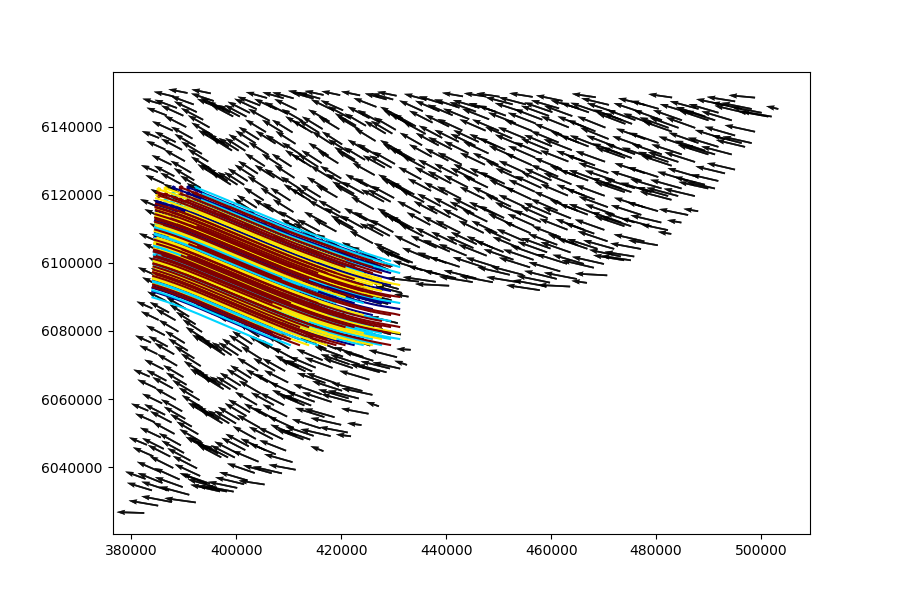

In [41]:
# посмотрим на получившиеся треки
fig, ax = plt.subplots(figsize=(9,6))
for p_type, states in p_type_states.items():
    color = point_types.loc[p_type, 'color']
    ax.quiver(xy[::10, 0], xy[::10, 1], current_velocity[::10, 0], current_velocity[::10, 1], scale=200, scale_units='width', alpha=0.5)
    ax.plot(states[:, :, 0], states[:, :, 1], color=color)
    ax.quiver(states[-1, :, 0], states[-1, :, 1], states[-1, :, 2], states[-1, :, 3], color=color, scale=20)

# ax.axis((bounds[0], bounds[2], bounds[1], bounds[3]))

In [36]:
p_type_states[1]

array([[[ 4.22356931e+05,  6.07589492e+06, -6.98990266e-02,
          3.91505489e-02],
        [ 4.13679348e+05,  6.09708571e+06, -5.18820564e-02,
          4.57849458e-02],
        [ 4.06737281e+05,  6.09002211e+06, -4.78997257e-02,
          4.63595991e-02],
        ...,
        [ 4.24092448e+05,  6.08119262e+06, -6.94867981e-02,
          3.87476569e-02],
        [ 4.13679348e+05,  6.09002211e+06, -5.30707828e-02,
          4.58995823e-02],
        [ 4.18885898e+05,  6.09002211e+06, -5.91377435e-02,
          4.41157818e-02]],

       [[ 4.22105294e+05,  6.07603587e+06, -6.94113239e-02,
          3.93931902e-02],
        [ 4.13492572e+05,  6.09725053e+06, -5.17216200e-02,
          4.57996277e-02],
        [ 4.06564842e+05,  6.09018901e+06, -4.78327854e-02,
          4.63731752e-02],
        ...,
        [ 4.23842295e+05,  6.08133211e+06, -6.89229360e-02,
          3.91996212e-02],
        [ 4.13488293e+05,  6.09018735e+06, -5.29283111e-02,
          4.59077843e-02],
        [ 4.186

In [19]:
# сейчас координаты в states мы рассчитали в метрах
# переведем их в wgs84, чтобы отобразить на карте

for states in p_type_states.values():
    for i in range(states.shape[0]):
        states[i, :, 0], states[i, :, 1] = transform(local_crs, wgs84, states[i, :, 0], states[i, :, 1])

<IPython.core.display.Javascript object>


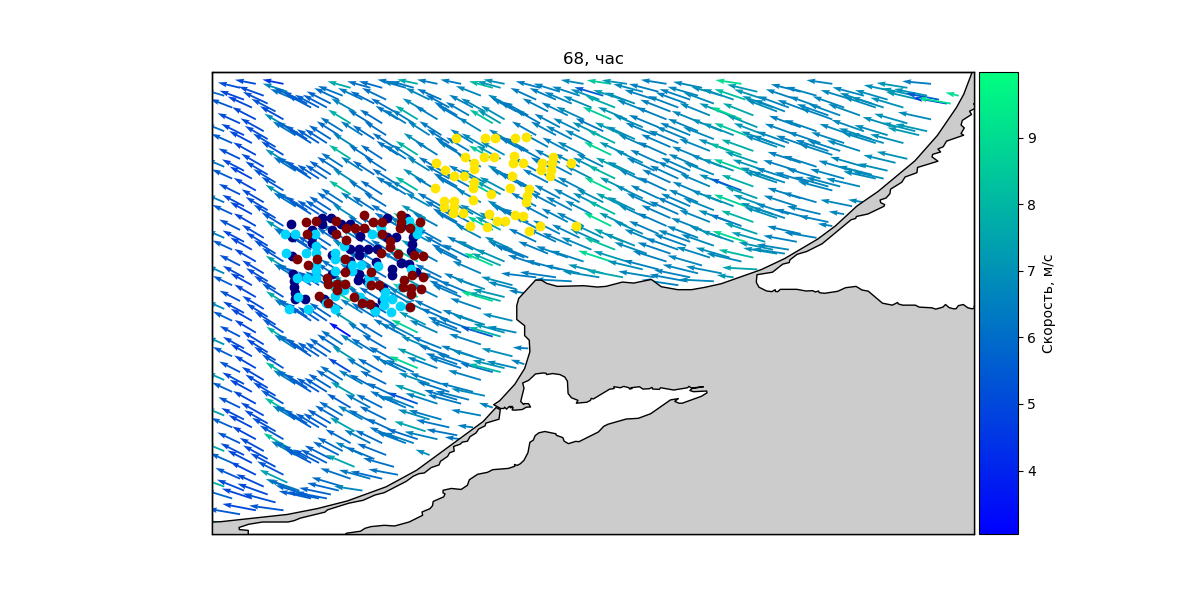

In [13]:
# рисуем анимацию

# создаем рисунок
fig, ax = plt.subplots(figsize=(12,6))

# добавляем континенты
m = Basemap(
    llcrnrlon=bounds_lonlat[0]-0.03,
    llcrnrlat=bounds_lonlat[1]-0.03,
    urcrnrlon=bounds_lonlat[2]+0.03,
    urcrnrlat=bounds_lonlat[3]+0.03,
    epsg="4326",
    resolution='h',
)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()

# добавляем поле скоростей
q = ax.quiver(
    lonlat[::10, 0],
    lonlat[::10, 1],
    current_velocity[::10, 0],
    current_velocity[::10, 1],
    np.linalg.norm(current_velocity, axis=1),
    scale=200,
    scale_units='width',
    cmap='winter',
)

# добавляем colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(q, cax=cax, label='Скорость, м/с')
lines = []
for p_type, states in p_type_states.items():
    color = point_types.loc[p_type, 'color']
    for i in range(states.shape[1]):
        lines.append(ax.plot([], [], color=color, linestyle='', marker='o')[0])

# инициализация линий для анимации
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# обновлении линий на каждой итерации
def update(frame):
    ax.set_title('{}, час'.format(frame*STEP//3600))
    line_idx = 0
    for p_type, states in p_type_states.items():
        for i in range(states.shape[1]):
            x = states[frame:frame+1, i, 0]
            y = states[frame:frame+1, i, 1]
            lines[line_idx].set_data(x, y)
            line_idx += 1
    return lines

# cоздаем и сохраняем анимацию
ani = animation.FuncAnimation(
    fig,
    update,
    frames=NUM_ITER-1,
    init_func=init,
    interval=100,
#     blit=True,
)
ani.save('out.mp4',  writer=animation.FFMpegFileWriter(bitrate=-1))

In [42]:
# выведем все данные в файл
all_points = []
point_idx = 0
for p_type, states in p_type_states.items():
    for i in range(states.shape[1]):
        df=pd.DataFrame(states[:, i, :], columns=['lon', 'lat', 'u', 'v'])
        df['point'] = point_idx
        df['point_type'] = p_type
        df.index.name = 'num_iter'
        df.reset_index(inplace=True)
        all_points.append(df)
        point_idx += 1
        
df = pd.concat(all_points, axis='rows')
df.loc[(df.lon < bounds_lonlat[0]) | (df.lon > bounds_lonlat[2]), 'lat'] = -999
df.loc[(df.lat < bounds_lonlat[1]) | (df.lat > bounds_lonlat[3]), 'lon'] = -999
df.u *= 100
df.v *= 100
df.to_csv('out.csv', index=False)

In [30]:
bounds_lonlat

array([19.19, 54.35, 21.06, 55.46])

In [32]:
df[df.lon>0].lon.min()

19.190018615087062

<IPython.core.display.Javascript object>


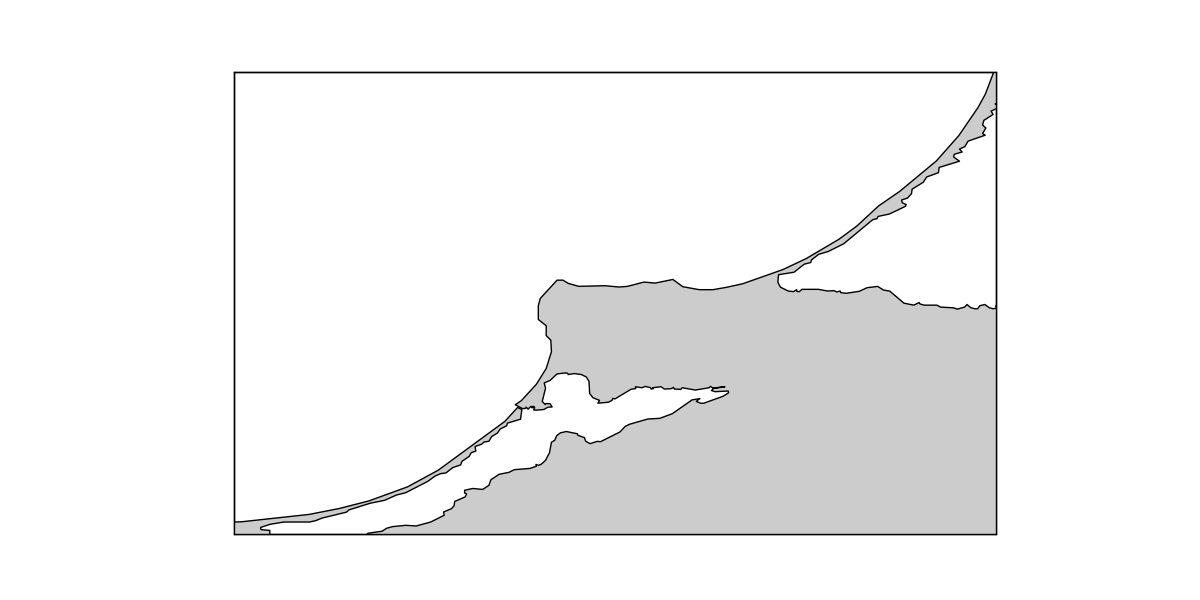

In [98]:
fig, ax = plt.subplots(figsize=(12,6))

# добавляем континенты
m = Basemap(
    llcrnrlon=bounds_lonlat[0]-0.03,
    llcrnrlat=bounds_lonlat[1]-0.03,
    urcrnrlon=bounds_lonlat[2]+0.03,
    urcrnrlat=bounds_lonlat[3]+0.03,
    epsg="4326",
    resolution='h',
)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()

In [99]:
len(m.coastpolygons)

2

In [109]:
from shapely.geometry import Polygon, MultiPolygon, Point
continent = MultiPolygon([Polygon(zip(*xy)) for xy in m.coastpolygons]) 

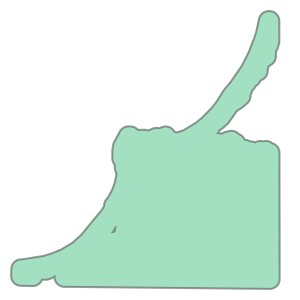

In [110]:
from particles.utils import transform_geometry
transform_geometry(continent, wgs84, local_crs).buffer(5_000)

In [111]:
p = Point(1,2)

In [112]:
continent.contains(p)

False

In [113]:
a=np.array([[1.2],[3.4]])

In [114]:
np.hstack([np.ones(row.number, dtype=int)*p_type for p_type, row in point_types.iterrows()])


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [143]:
speed_params = point_types.loc[np.array([1,1,1,2,2])].speed_param.values.reshape(-1,1)
speed_params

array([[0.01035612],
       [0.01035612],
       [0.01035612],
       [0.00597911],
       [0.00597911]])

In [144]:
(speed_params @ W.reshape(1, -1)+C)

array([[1.55341824, 1.55341824],
       [1.55341824, 1.55341824],
       [1.55341824, 1.55341824],
       [0.89686644, 0.89686644],
       [0.89686644, 0.89686644]])

In [133]:
(1+speed_params)

array([[1.01035612],
       [1.01035612],
       [1.01035612],
       [1.00597911],
       [1.00597911]])

In [142]:
(speed_params @ W.reshape(1, -1)+C) / (1+speed_params)

array([[1.53749575, 1.53749575],
       [1.53749575, 1.53749575],
       [1.53749575, 1.53749575],
       [0.89153585, 0.89153585],
       [0.89153585, 0.89153585]])

In [153]:
num_iter = 4
num_points = 4

iteration = 2

a=np.ones(32).reshape(num_iter,num_points,2)
b=np.ones(10).reshape(num_points+1, 2)*-1 # + 1 point

diff = b.shape[0] - a.shape[1]
if diff:
    c = np.ones([num_iter, num_points+diff, 2], dtype=float) * np.nan
    c[:iteration, 0:a.shape[1] , :] = a[:iteration, :, :]
    c[iteration, :, :] = b
c

array([[[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [nan, nan]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [nan, nan]],

       [[-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]]])

In [147]:
np.concatenate([a,b], axis=)

array([0, 1, 2, 0, 1, 2, 3])